### import

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import holidays

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from xgboost import XGBRegressor, plot_tree
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# = = = = = =
# own stuff

os.chdir("C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC")
from data_prepro import get_energy_data_today, create_dummy_df

In [2]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


### Dummy Creation / Feature Engineering

#### holidays

In [4]:
# # get all years in dataframe
# uniq_yrs = [2016]

# # get holidays for germany for all states and combine them into one single dict
# states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 
#             'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']

# holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
# for state in states:
#     holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

# # sort holidays
# holidays_de = dict(sorted(holidays_de.items()))
# print(holidays_de)

{datetime.date(2016, 1, 1): 'Neujahr', datetime.date(2016, 1, 6): 'Heilige Drei Könige', datetime.date(2016, 3, 25): 'Karfreitag', datetime.date(2016, 3, 27): 'Ostersonntag', datetime.date(2016, 3, 28): 'Ostermontag', datetime.date(2016, 5, 1): 'Erster Mai', datetime.date(2016, 5, 5): 'Christi Himmelfahrt', datetime.date(2016, 5, 15): 'Pfingstsonntag', datetime.date(2016, 5, 16): 'Pfingstmontag', datetime.date(2016, 5, 26): 'Fronleichnam', datetime.date(2016, 8, 15): 'Mariä Himmelfahrt', datetime.date(2016, 10, 3): 'Tag der Deutschen Einheit', datetime.date(2016, 10, 31): 'Reformationstag', datetime.date(2016, 11, 1): 'Allerheiligen', datetime.date(2016, 11, 16): 'Buß- und Bettag', datetime.date(2016, 12, 25): 'Erster Weihnachtstag', datetime.date(2016, 12, 26): 'Zweiter Weihnachtstag'}


#### create dummies

In [5]:
def create_dummy_df(df, hour_method='simple', holiday_method='simple'):

    df_out = df.copy()

    # binary dummy var for each month
    dummy_month = pd.get_dummies(df_out['timestamp_CET'].dt.month, prefix='month').astype(int)
    # leave out first month to avoid multicollinearity
    dummy_month = dummy_month.iloc[:, 1:]

    # binary dummy var for each weekday
    dummy_weekday = pd.get_dummies(df_out['timestamp_CET'].dt.weekday, prefix='weekday').astype(int)
    # leave out first weekday to avoid multicollinearity
    dummy_weekday = dummy_weekday.iloc[:, 1:]

    # - - - - - - - - -
    # concat dummies
    df_out = pd.concat([df_out, dummy_month], axis=1)
    df_out = pd.concat([df_out, dummy_weekday], axis=1)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # create hour dummies

    if hour_method == 'simple':

        # binary dummy var for each hour
        dummy_hour = pd.get_dummies(df_out['timestamp_CET'].dt.hour, prefix='hour').astype(int)
        # leave out first hour to avoid multicollinearity
        dummy_hour = dummy_hour.iloc[:, 1:]
        df_out = pd.concat([df_out, dummy_hour], axis=1)

    if hour_method == 'seasonal':

        # separate hourly dummy vars for summer and winter months
        summer_months = [4, 5, 6, 7, 8, 9]
        df_out['is_summer'] = df_out['timestamp_CET'].dt.month.isin(summer_months).astype(int)

        # create dummy variables for each hour in summer months
        for hr in range(1, 24):
            # skip hour 0 in summer to avoid multicollinearity
            df_out[f'hour_{hr}_summer'] = ((df_out['is_summer'] == 1) & (df_out['timestamp_CET'].dt.hour == hr)).astype(int)

        for hr in range(1, 24):
            # skip hour 0 in winter to avoid multicollinearity
            df_out[f'hour_{hr}_winter'] = ((df_out['is_summer'] == 0) & (df_out['timestamp_CET'].dt.hour == hr)).astype(int)

        # drop is_summer
        df_out.drop(columns=['is_summer'], inplace=True)

    if hour_method == 'monthly':

        # separate hourly dummy vars for EVERY month
        month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
                    6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
                    11: 'November', 12: 'December'}

        for m_idx in range(1, 13):
            
            m_name = month_dict[m_idx][:3].lower() # short version of month name

            for hr in range(1, 24):
                # skip hour 0 to avoid multicollinearity
                df_out[f'hour_{hr}_{m_name}'] = ((df_out['timestamp_CET'].dt.month == m_idx) & 
                                                 (df_out['timestamp_CET'].dt.hour == hr)).astype(int)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # create holiday dummies

    # get all years in dataframe
    uniq_yrs = df_out['timestamp_CET'].dt.year.unique()

    # get holidays for germany for all states and combine them into one single dict
    states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 
              'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']
    
    holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
    for state in states:
        holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

    # sort holidays
    holidays_de = dict(sorted(holidays_de.items()))
    holidays_de_dates = list(holidays_de.keys())

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    # only one holiday dummy for all holidays
    if holiday_method == 'simple':

        df_out['is_holiday'] = df_out['timestamp_CET'].dt.date.isin(holidays_de_dates).astype(int)

    # create separate dummies for each holiday ...
    if holiday_method == 'separate' :

        # newyears + silvester ist kein feiertag aber die meisten nehmen trotzdem frei
        # create dummy variable for all rows where timestamp_CET is 12.31 or 01.01
        df_out['is_holiday_newyear_d31'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 31))
        df_out['is_holiday_newyear_d01'] = ((df_out['timestamp_CET'].dt.month == 1) & (df_out['timestamp_CET'].dt.day == 1))

        # Heilige Drei Könige (01.06)
        threekings_dates = [k for k, v in holidays_de.items() if v == 'Heilige Drei Könige']
        df_out['is_holiday_threekings'] = df_out['timestamp_CET'].dt.date.isin(threekings_dates)

        # Karfreitag (easter - 2d)
        karfreitag_dates = [k for k, v in holidays_de.items() if v == 'Karfreitag']
        df_out['is_holiday_karfreitag'] = df_out['timestamp_CET'].dt.date.isin(karfreitag_dates)

        # Eastermonday (easter + 1d)
        easter_dates = [k for k, v in holidays_de.items() if v == 'Ostermontag']
        df_out['is_holiday_easter'] = df_out['timestamp_CET'].dt.date.isin(easter_dates)

        # Erster Mai / Tag der Arbeit (05.01)
        erstermai_dates = [k for k, v in holidays_de.items() if v == 'Erster Mai']
        df_out['is_holiday_erstermai'] = df_out['timestamp_CET'].dt.date.isin(erstermai_dates)

        # Christi Himmelfahrt (easter + 39d)
        himmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Christi Himmelfahrt']
        df_out['is_holiday_himmelfahrt'] = df_out['timestamp_CET'].dt.date.isin(himmelfahrt_dates)

        # Pfingstmontag (easter + 50d)
        pfingstmontag_dates = [k for k, v in holidays_de.items() if v == 'Pfingstmontag']
        df_out['is_holiday_pfingstmontag'] = df_out['timestamp_CET'].dt.date.isin(pfingstmontag_dates)

        # Fronleichnam (easter + 60d)
        fronleichnam_dates = [k for k, v in holidays_de.items() if v == 'Fronleichnam']
        df_out['is_holiday_fronleichnam'] = df_out['timestamp_CET'].dt.date.isin(fronleichnam_dates)

        # Maria Himmelfahrt (08.15)
        mariahimmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Mariä Himmelfahrt']
        df_out['is_holiday_mariahimmelfahrt'] = df_out['timestamp_CET'].dt.date.isin(mariahimmelfahrt_dates)

        # Tag der Deutschen Einheit (10.03)
        einheit_dates = [k for k, v in holidays_de.items() if v == 'Tag der Deutschen Einheit']
        df_out['is_holiday_einheit'] = df_out['timestamp_CET'].dt.date.isin(einheit_dates)

        # Reformationstag (10.31)
        reformationstag_dates = [k for k, v in holidays_de.items() if v == 'Reformationstag']
        df_out['is_holiday_reformationstag'] = df_out['timestamp_CET'].dt.date.isin(reformationstag_dates)

        # Allerheiligen (11.01)
        allerheiligen_dates = [k for k, v in holidays_de.items() if v == 'Allerheiligen']
        df_out['is_holiday_allerheiligen'] = df_out['timestamp_CET'].dt.date.isin(allerheiligen_dates)

        # christmas = list of datetimes from 12.24 to 12.26 
        df_out['is_holiday_xmas_d23'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 23))
        df_out['is_holiday_xmas_d24'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 24))
        df_out['is_holiday_xmas_d25'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 25))
        df_out['is_holiday_xmas_d26'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 26))

        # brückentage zwischen weihnachten und neujahr
        # 12.27, 12.28, 12.29, 12.30
        df_out['is_holiday_xmas2newyear'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day.isin([27,28,29,30])))

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # reformat all columns that begin with "is_holiday" to int
        for col in df_out.columns:
            if col.startswith('is_holiday'):
                df_out[col] = df_out[col].astype(int)

    return df_out

### Lin Reg with Dummies

In [10]:
def fit_lin_reg(df, method='ols', test_perc=0.01, drop_cols=None, title_addon=None):

    if drop_cols is None:
        drop_cols = ['timestamp_CET']
    else:
        drop_cols.append('timestamp_CET')

    # drop columns
    df = df.drop(drop_cols, axis=1)

    # do train test split manually
    n_total = df.shape[0]
    n_train = int((1-test_perc) * n_total)
    n_test = n_total - n_train

    X_train = df.iloc[:n_train]
    X_test = df.iloc[-n_test:]

    y_train = X_train['gesamt']
    y_test = X_test['gesamt']

    X_train = X_train.drop(['gesamt'], axis=1)
    X_test = X_test.drop(['gesamt'], axis=1)

    # Add a constant term to the features matrix for statsmodels
    X_train = sm.add_constant(X_train)
    # Create model using OLS (Ordinary Least Squares)
    model = sm.OLS(y_train, X_train)

    if method == 'ols' :

        results = model.fit()
        print(results.summary())

        r_sqrd = results.rsquared
        r_sqrd_adj = results.rsquared_adj

    elif method == 'ela_net' :

        results = model.fit_regularized(method = 'elastic_net')
        print(results.params.to_string())
        # [TODO] how to get r squared ???

    # Add a constant term to the features matrix for the test set
    X_test = sm.add_constant(X_test, has_constant='add')

    # PROBLEM eg if first column is "is_summer" and the test set is in summer, then the first column is already constant = 1 everywhere
    # BUT we still want to add a constant row to make sure the model works / has the right dimension
    # SO we set has_constant = 'add' to force the constant row to be added

    # Make predictions
    y_pred = results.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")

    title = f"Lin Reg using {method} and {len(X_train.columns)} predictors"
    
    if method == 'ols' :
        title = f"{title}, r2={r_sqrd:.4f}, r2_adj={r_sqrd_adj:.4f}"
    # if method == 'ridge' :
    #     title = ...
    
    title = f"{title}, {title_addon}"

    # Plot out of sample predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_test, label='test')
    plt.plot(y_test.index, y_pred, label=f'predicted, rmse = {rmse:.2f}')
    
    plt.title(title)
    plt.legend()
    plt.show()

    return X_train, X_test, y_train, y_test, results, y_pred


                            OLS Regression Results                            
Dep. Variable:                 gesamt   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     3158.
Date:                Fri, 29 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:16:48   Log-Likelihood:            -2.7901e+05
No. Observations:               29328   AIC:                         5.582e+05
Df Residuals:                   29246   BIC:                         5.589e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

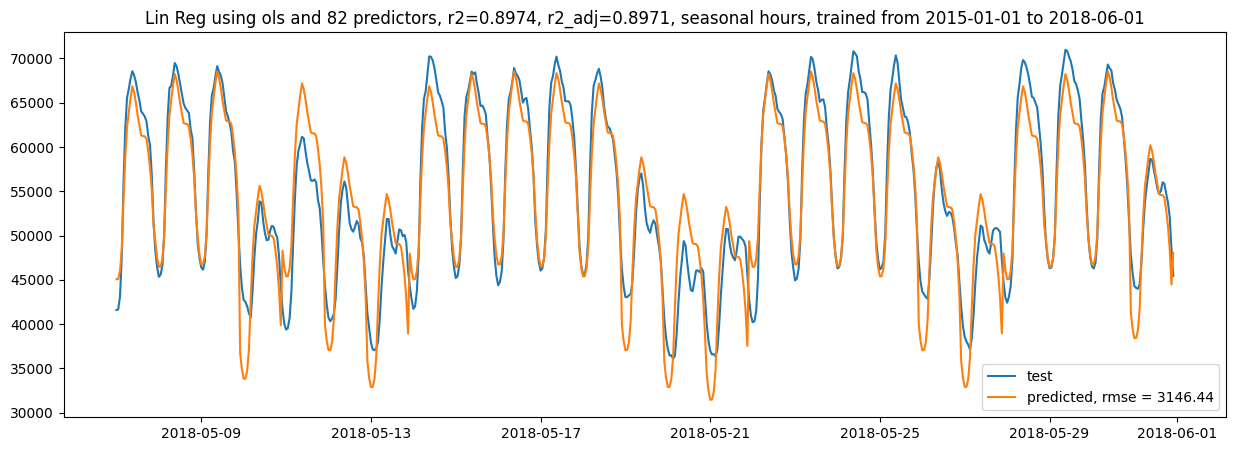

const                          54081.182770
month_2                          321.567238
month_3                        -2166.266033
month_4                        -4186.631809
month_5                        -5571.074111
month_6                        -5820.396663
month_7                        -5668.726042
month_8                        -6834.942195
month_9                        -5414.603236
month_10                       -4566.920515
month_11                       -1131.509182
month_12                         -62.917127
weekday_1                       1541.298331
weekday_2                       1827.605687
weekday_3                       1640.665222
weekday_4                        474.458746
weekday_5                      -7860.951359
weekday_6                     -12021.064895
hour_1_summer                  -2547.086364
hour_2_summer                  -3573.855984
hour_3_summer                  -3552.173078
hour_4_summer                  -2660.966667
hour_5_summer                   

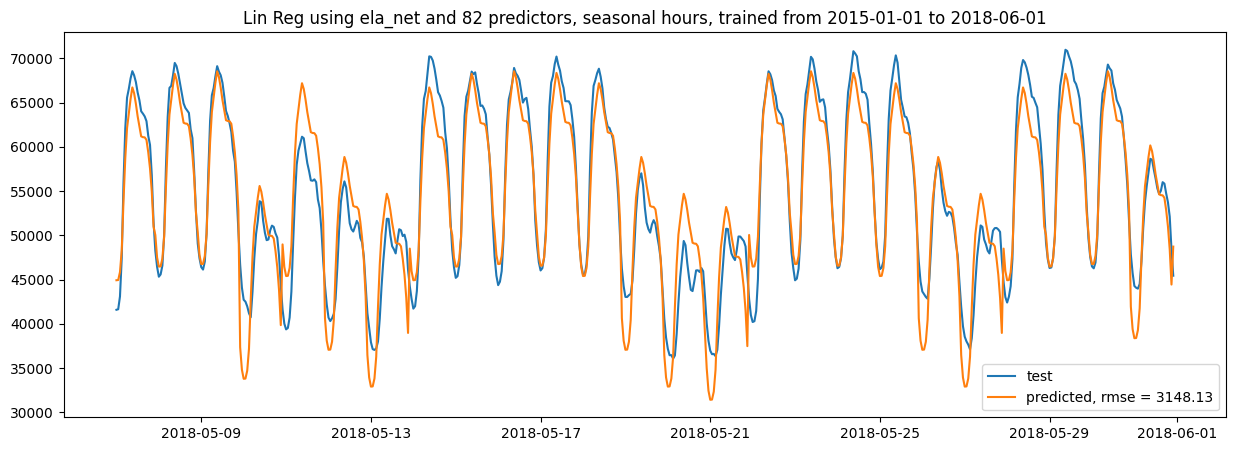

In [11]:
# hr_meths = ['simple', 'seasonal', 'monthly']
hr_meths = ['seasonal']

# take smaller dataset
start = '2015-01-01'
end = '2018-06-01'
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) & 
                                (df_energy['timestamp_CET'] <= end)]
        

for hour_method in hr_meths:

    df_energy_dummy = create_dummy_df(df_energy_small, hour_method=hour_method, holiday_method='separate')
                          
    # fit model on all data and another fit without "is_weekend" and "is_night"
    title_add = f'{hour_method} hours, trained from {start} to {end}'
    res_ols = fit_lin_reg(df_energy_dummy, test_perc=0.02, method='ols', title_addon=title_add)
    res_ela_net = fit_lin_reg(df_energy_dummy, test_perc=0.02, method='ela_net', title_addon=title_add)


#### error analysis

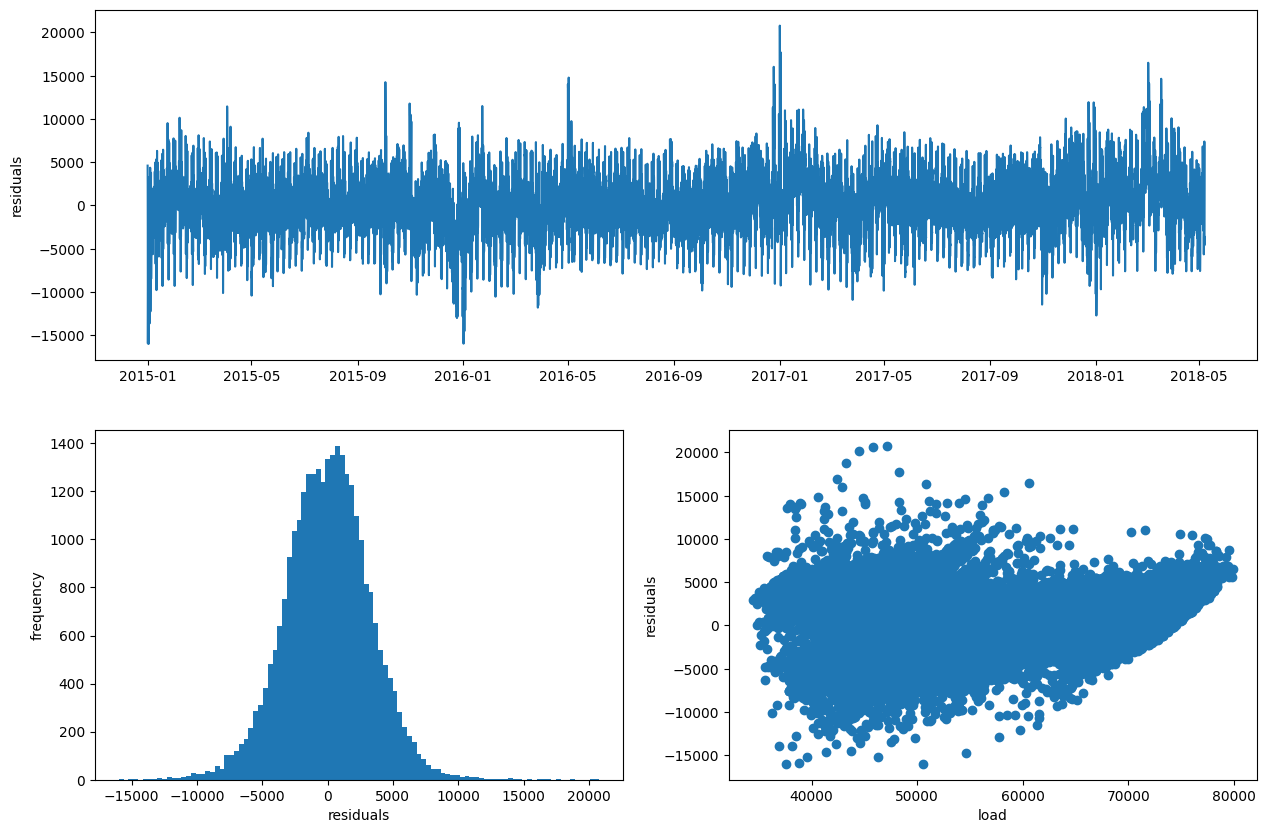

In [12]:
# take in sample errors and check assumptions of lin reg
    # check for distribution (normality) of residuals
    # check for autocorrelation in residuals
    # check for heteroscedasticity

X_train, X_test, y_train, y_test, fit, y_pred = res_ela_net

# calc residuals in sample
residuals = y_train - fit.predict(X_train)

# plot
fig = plt.figure(figsize=(15, 10))
# check for autocorrelation in residuals 
ax1 = plt.subplot(2,2,(1,2))
ax1.plot(residuals)
ax1.set_ylabel('residuals')
# check for normality
ax2 = plt.subplot(2,2,3)
ax2.hist(residuals, bins=100)
ax2.set_xlabel('residuals')
ax2.set_ylabel('frequency')
# check for heteroscedasticity
ax3 = plt.subplot(2,2,4)
ax3.scatter(y_train, residuals)
ax3.set_xlabel('load')
ax3.set_ylabel('residuals')
plt.show()

### Lin Reg with Fourier Terms

#### toy data

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.138e+06
Date:                Tue, 02 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:09:55   Log-Likelihood:                 1907.7
No. Observations:                 499   AIC:                            -3737.
Df Residuals:                     460   BIC:                            -3573.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.082e-17      0

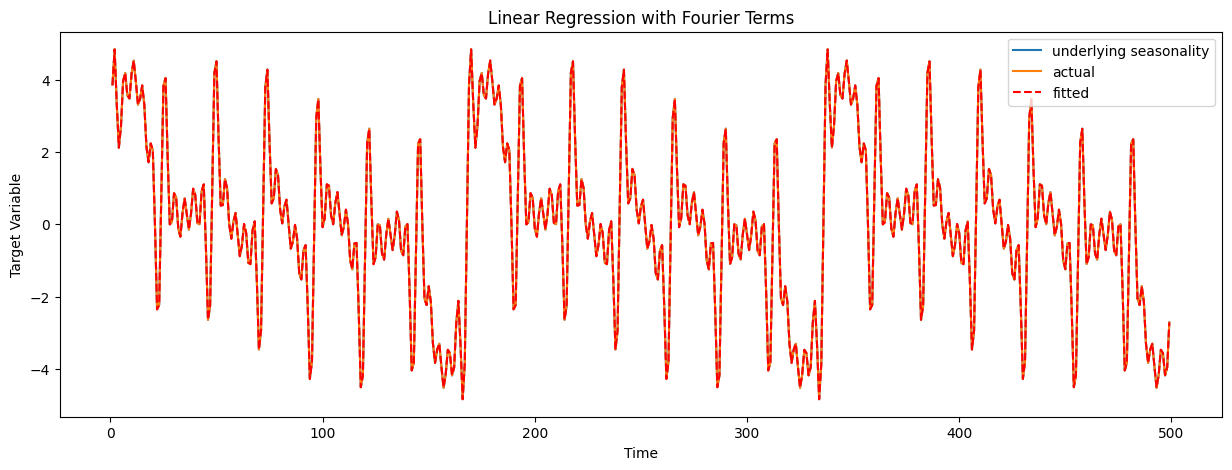

In [8]:
# = = = = = = = = = = = = = = = = = = = = = = 
# Generate toy data with variable seasonality

np.random.seed(42)
t = np.arange(1, 500, 1)

# Create a linear trend
# trend = 0.5 * t + 3
trend = 0

# Add some random noise
# noise = np.random.normal(0, 1, size=len(t))
noise = 0

# Create variable seasonality using Fourier terms
n_fourier = 5  # Number of Fourier terms
m_vals = [24, 7*24] # seasonality / period

seasonality = np.zeros_like(t, dtype=float)
for i in range(1, n_fourier + 1):
    for m in m_vals:
        seasonality += np.sin(2 * np.pi * i * t / m) 

# Combine trend, seasonality, and noise to create the target variable
target = trend + seasonality + noise

# = = = = = = = = = = = = = = = = = = = = = = 
# Regression

# create features DataFrame X
data = pd.DataFrame({'Time': t, 'Target': target})

# add fourier terms as features

n_fourier_reg = 10  # number of fourier terms in regression
m_vals_reg = [24, 7*24]
for i in range(1, n_fourier_reg + 1):
    for m in m_vals_reg:
        data[f'Fourier_{i}_sin_{m}'] = np.sin(2 * np.pi * i * t / m)
        data[f'Fourier_{i}_cos_{m}'] = np.cos(2 * np.pi * i * t / m)

# Perform linear regression with Fourier terms
X = sm.add_constant(data.iloc[:, 2:]) # remove time and target cols
y = data['Target']

model = sm.OLS(y, X).fit()
print(model.summary())

# = = = = = = = = = = = = = = = = = = = = = =
# Plot the original data and the fitted values
plt.figure(figsize=(15, 5))
plt.plot(t, seasonality, label='underlying seasonality')
plt.plot(t, target, label='actual')
plt.plot(t, model.fittedvalues, label='fitted', linestyle='--', color='red')
plt.title('Linear Regression with Fourier Terms')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

#### energy data

                            OLS Regression Results                            
Dep. Variable:                 gesamt   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     7414.
Date:                Tue, 02 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:47:17   Log-Likelihood:            -3.3551e+05
No. Observations:               35064   AIC:                         6.711e+05
Df Residuals:                   35027   BIC:                         6.714e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

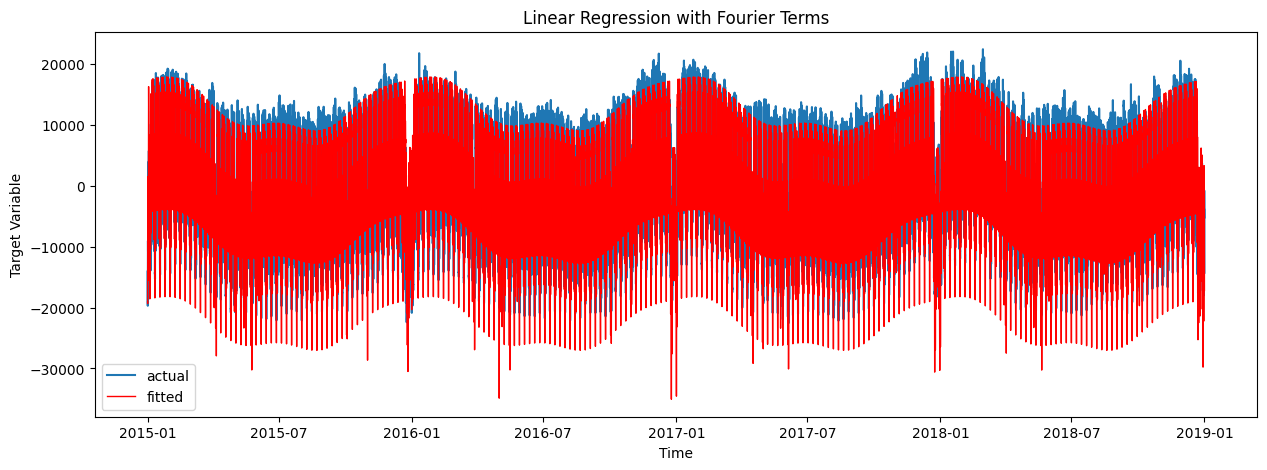

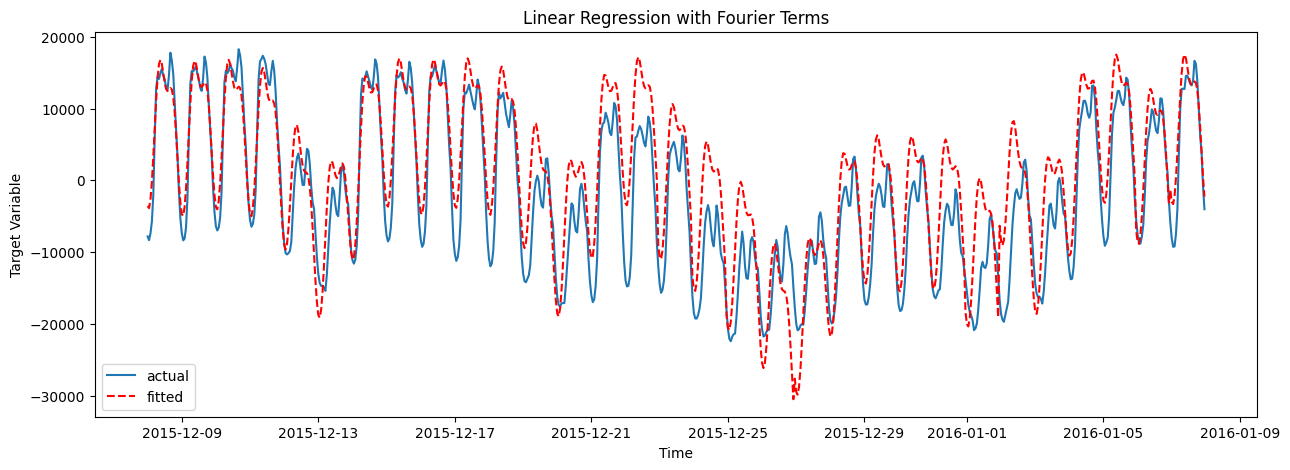

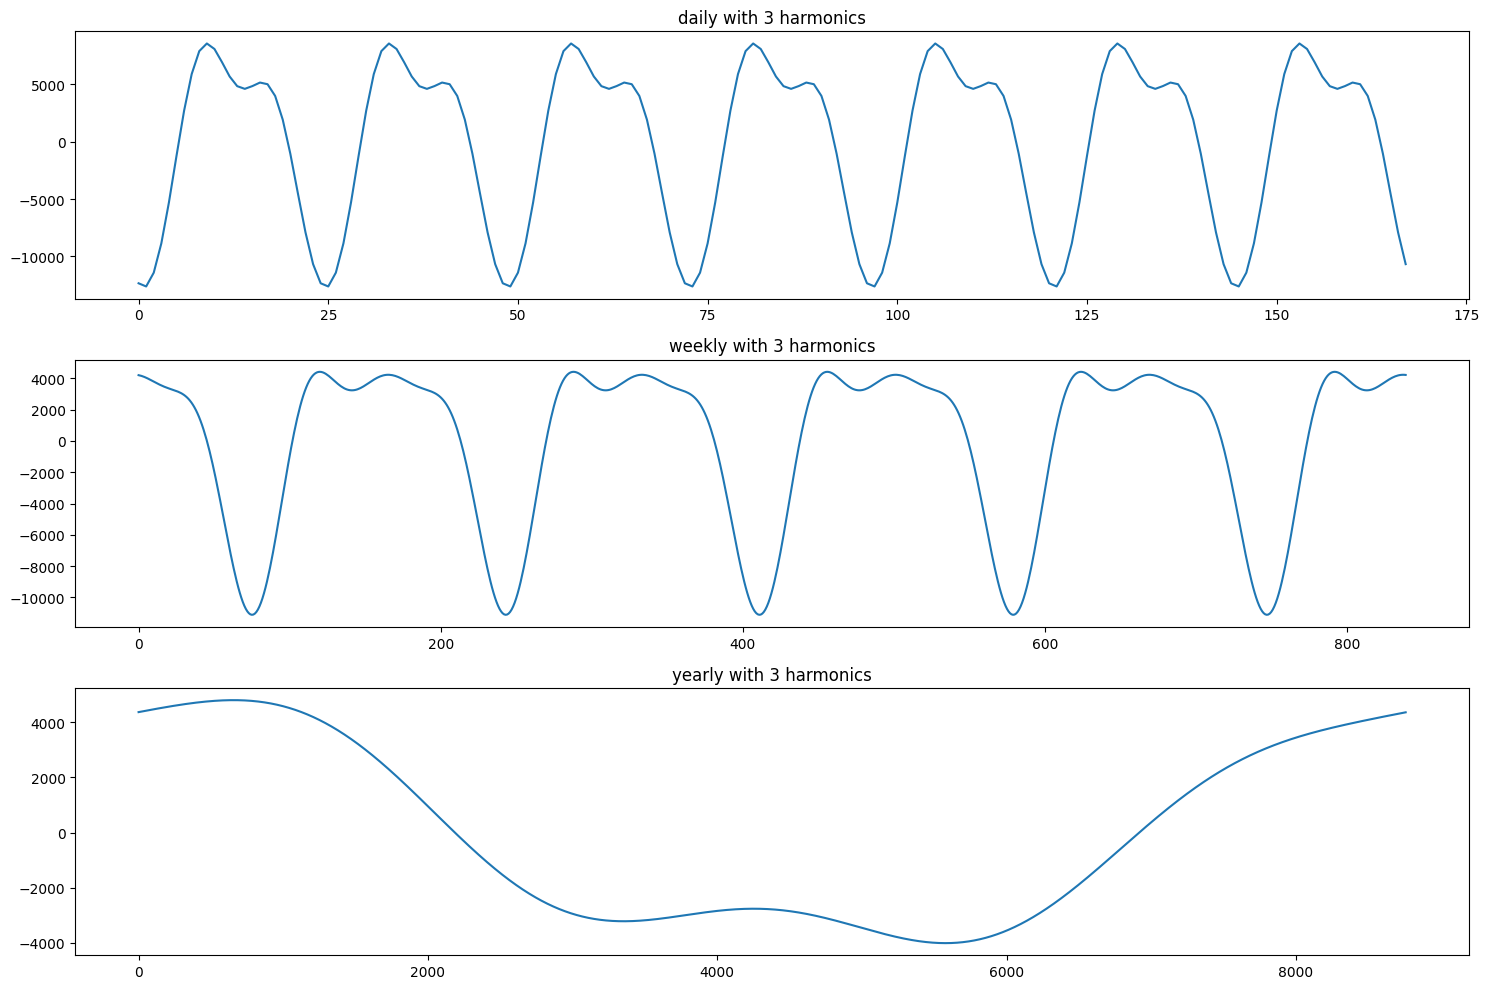

In [199]:
# take smaller dataset
start   = '2015-01-01'
end     = '2019-01-01'
data = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                     (df_energy['timestamp_CET'] <= end)].copy()

# add holiday dummies
data = create_dummy_df(data, month_method='none', weekday_method='none', hour_method='none', holiday_method='separate')
data.head(5)

# add fourier terms as features
n_vals = [3, 3, 3] # number of fourier terms in regression
m_vals = [24, 7*24, 365.25*24] # seasonality / periodicity

t = np.arange(0, len(data), 1)

for idx, m in enumerate(m_vals):
    n_fourier_terms = n_vals[idx]
    for i in range(1, n_fourier_terms+1):
        data[f'Fourier_{i}_sin_{m}'] = np.sin(2 * np.pi * i * t / m)
        data[f'Fourier_{i}_cos_{m}'] = np.cos(2 * np.pi * i * t / m)

# i = 1 : sin( 2pi*t / m)
# i = 2 : sin( 4pi*t / m) = sin( 2 * 2pi*t / m) = 2nd harmonic
# i = 3 : sin( 6pi*t / m) = sin( 3 * 2pi*t / m) = 3rd harmonic
        
# so the 7th harmonic of m = 7*24 corresponds with the 1st harmonic of m = 24
# i = 7 : sin( 7 * 2pi*t / 7*24) = sin( 2pi*t / 24 )

# and the 365.25 th and 365.25/7 th harmonic of m = 365.25*24 correspond with the 1st of m = 24 and 7*24
# but since the harmonics are all integer multiples of the fundamental frequency, its fine
        
# Add a constant term to the features matrix for statsmodels
X = sm.add_constant(data.iloc[:,2:])
y = data['gesamt'] - data['gesamt'].mean()

# = = = = = = = = = = = = = = = = = = = = = = 
# Regression

model = sm.OLS(y, X).fit()
print(model.summary())

# = = = = = = = = = = = = = = = = = = = = = =
# Plot the original data and the fitted values
plt.figure(figsize=(15, 5))
plt.plot(y, label='actual', ls='-')
plt.plot(model.fittedvalues, label='fitted', ls='-', lw=1, color='red')
plt.title('Linear Regression with Fourier Terms')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

# = = = = = = = = = = = = = = = = = = = = = = 
# Plot 1 month of the data and the fitted values for more detailed view
m_idx = 11

plt.figure(figsize=(15, 5))
plt.plot(y[m_idx*24*31:(m_idx+1)*24*31], label='actual')
plt.plot(model.fittedvalues[m_idx*24*31:(m_idx+1)*24*31], label='fitted', linestyle='--', color='red')
plt.title('Linear Regression with Fourier Terms')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

params = model.params.values[19:] # remove first 19 params = 1 const + 18 holiday dummies

# = = = = = = = = = = = = = = = = = = = = = = =
# reconstruct the seasonalities from fitted parameters
t_short = np.arange(0, 24*365, 1)
seasonalities = np.zeros((len(m_vals), len(t_short)))
param_idx = 0

for m_idx, m in enumerate(m_vals):
    
    n_fourier_terms = n_vals[m_idx]
    
    for i in range(1, n_fourier_terms+1):
    
        amp1 = params[param_idx]
        param_idx += 1
        amp2 = params[param_idx]
        param_idx += 1
        f1 = amp1 * np.sin(2 * np.pi * i * t_short / m)
        f2 = amp2 * np.cos(2 * np.pi * i * t_short / m)
        seasonalities[m_idx] += f1 + f2

# = = = = = = = = = = = = = = = = = = = = = = =
# Plot the seasonalities
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
season_names = ['daily', 'weekly', 'yearly']

for idx, ax in enumerate(axes):
    if idx == 0:
        ax.plot(seasonalities[idx][:24*7])
    elif idx == 1:
        ax.plot(seasonalities[idx][:24*7*5])
    elif idx == 2:
        ax.plot(seasonalities[idx])
    ax.set_title(f"{season_names[idx]} with {n_vals[idx]} harmonics")

plt.tight_layout()
plt.show()

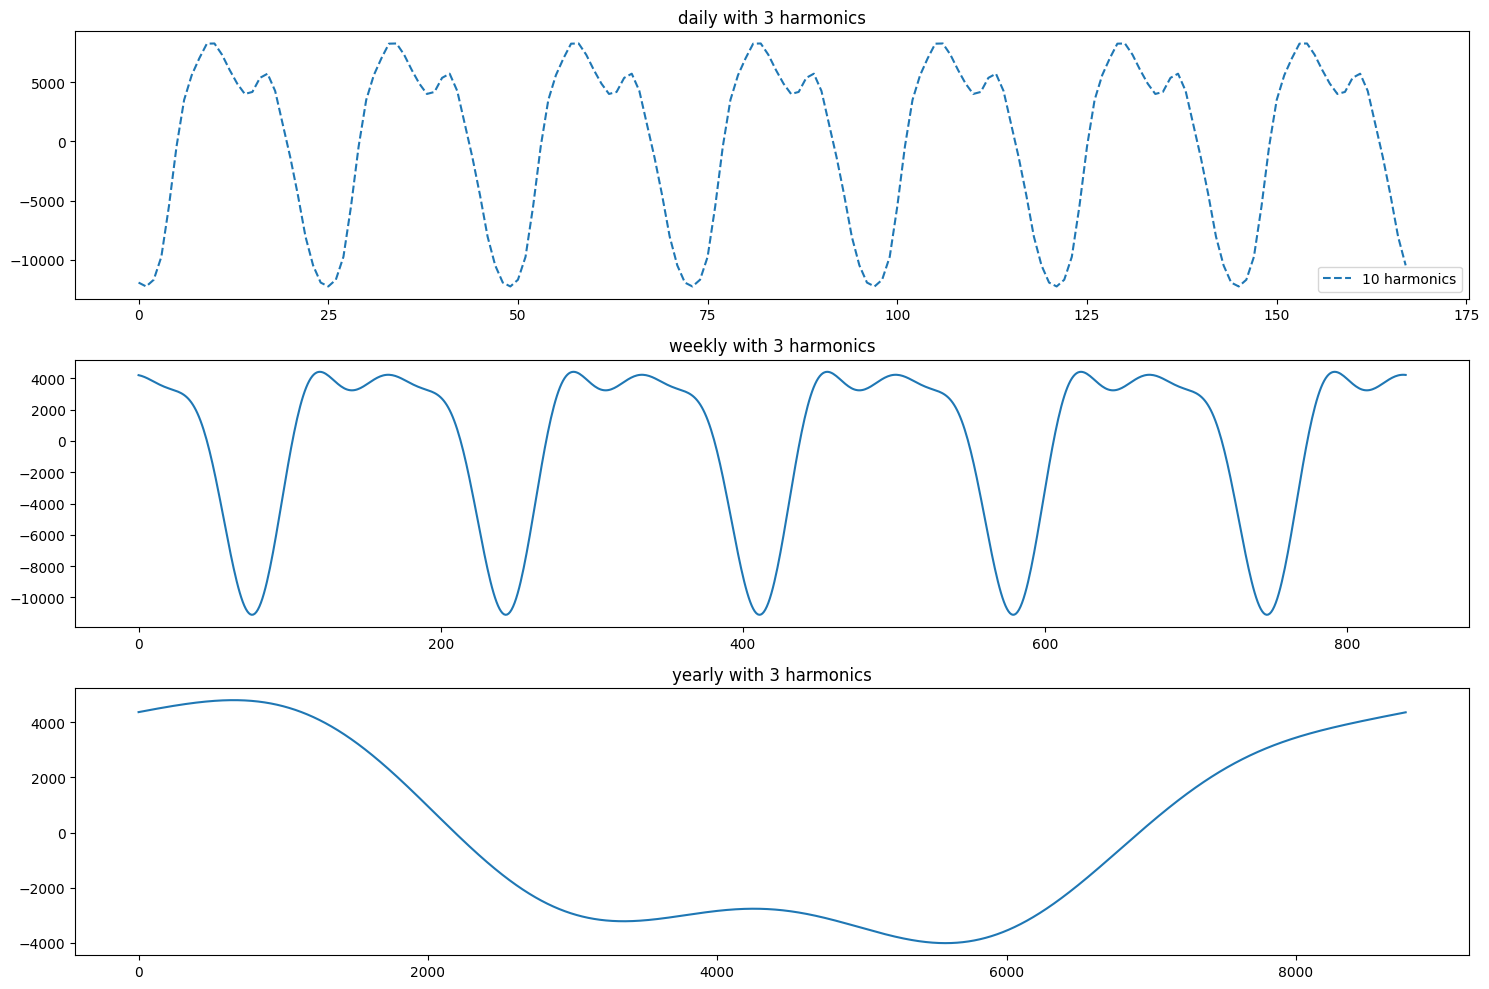

In [209]:
# seasonalities_10 = seasonalities
# seasonalities_3 = seasonalities

# = = = = = = = = = = = = = = = = = = = = = = =
# Plot the seasonalities
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
season_names = ['daily', 'weekly', 'yearly']

for s_idx, seasonailities in enumerate([seasonalities_3, seasonalities_10]):

    for idx, ax in enumerate(axes):
        if idx == 0:
            if s_idx == 0:
                ax.plot(seasonalities_3[idx][:24*7], label=f'3 harmonics', ls='-')
            else:
                ax.plot(seasonalities_10[idx][:24*7], label=f'10 harmonics', ls='--')
            ax.legend()
        elif idx == 1:
            ax.plot(seasonalities[idx][:24*7*5])
        elif idx == 2:
            ax.plot(seasonalities[idx])
        ax.set_title(f"{season_names[idx]} with {n_vals[idx]} harmonics")

plt.tight_layout()
plt.show()

#### grid search for best harmonics

In [39]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from itertools import product

In [ ]:
# Define the parameter grid
param_values = [1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 20]
# Generate all permutations of 3 parameters
permutations = list(product(param_values, repeat=3))
n_iter = len(permutations)

# Initialize matrix to store parameters and metrics
grid_search_res = np.zeros((len(permutations), 8))

# take smaller dataset
start = '2015-01-01'
end = '2023-01-01'
data = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                     (df_energy['timestamp_CET'] <= end)].copy()

y = data['gesamt'] - data['gesamt'].mean()

t = np.arange(0, len(data), 1)

# Grid search
for n_idx, n_vals in enumerate(permutations):

    # print n_idx and update it each time in place using special end character syntax
    print(f'\r{n_idx} / {n_iter}', end='')

    data_temp = data.copy()

    for m_idx, m in enumerate(m_vals):
        n_fourier_terms = n_vals[m_idx]
        for i in range(1, n_fourier_terms + 1):
            data_temp[f'Fourier_{i}_sin_{m}'] = np.sin(2 * np.pi * i * t / m)
            data_temp[f'Fourier_{i}_cos_{m}'] = np.cos(2 * np.pi * i * t / m)

    # Add a constant term to the features matrix for statsmodels
    X = sm.add_constant(data_temp.iloc[:, 2:])
    # OLS regression
    results = sm.OLS(y, X).fit()
    
    # Metrics
    r2 = results.rsquared
    r2_adj = results.rsquared_adj
    aic = results.aic
    bic = results.bic
    log_lik = results.llf

    # Additional metrics
    in_samp_pred = results.fittedvalues
    mse = mean_squared_error(y, in_samp_pred)
    mape = mean_absolute_percentage_error(y, in_samp_pred)
    mae = mean_absolute_error(y, in_samp_pred)

    # Add to grid search results
    grid_search_res[n_idx] = [mse, mape, mae, r2, r2_adj, aic, bic, log_lik]

30 / 1331

KeyboardInterrupt: 

In [89]:
metrics = ['mse', 'mape', 'mae', 'r2', 'r2_adj', 'aic', 'bic', 'log_lik']
res_df = pd.DataFrame(grid_search_res, columns=metrics)
# display(res_df)

# find best model based on each criteria
# metrics to be minimized
min_metrics = ['mse', 'mape', 'mae', 'aic', 'bic']
# metrics to be maximized
max_metrics = ['r2', 'r2_adj', 'log_lik']

for metric in min_metrics:
    best_idx = res_df[metric].idxmin()
    print(f'Best model for {metric}: {permutations[best_idx]}')

for metric in max_metrics:
    best_idx = res_df[metric].idxmax()
    print(f'Best model for {metric}: {permutations[best_idx]}')

display(res_df)

Best model for mse: (20, 20, 20)
Best model for mape: (20, 4, 20)
Best model for mae: (10, 20, 20)
Best model for aic: (10, 20, 20)
Best model for bic: (10, 20, 20)
Best model for r2: (20, 20, 20)
Best model for r2_adj: (10, 20, 20)
Best model for log_lik: (20, 20, 20)


,mse,mape,mae,r2,r2_adj,aic,bic,log_lik
0,3.307243e+07,3.023197,4503.331265,0.668950,0.668922,1.413240e+06,1.413304e+06,-706612.799466
1,3.278328e+07,3.028743,4483.499982,0.671844,0.671807,1.412628e+06,1.412710e+06,-706304.888198
2,3.172419e+07,3.162326,4431.564534,0.682446,0.682400,1.410329e+06,1.410430e+06,-705153.420934
3,3.137017e+07,2.962818,4413.978699,0.685989,0.685935,1.409546e+06,1.409665e+06,-704759.928583
4,3.072762e+07,2.739226,4383.094543,0.692421,0.692360,1.408099e+06,1.408236e+06,-704034.265036
...,...,...,...,...,...,...,...,...
507,1.440116e+07,2.781803,2663.658950,0.855847,0.855665,1.355100e+06,1.355915e+06,-677460.887710
508,1.375719e+07,2.970857,2624.546138,0.862293,0.862116,1.351896e+06,1.352729e+06,-675856.822149
509,1.184102e+07,2.502246,2474.847409,0.881473,0.881304,1.341397e+06,1.342322e+06,-670597.504857
510,1.095338e+07,2.293435,2390.288824,0.890358,0.890186,1.335953e+06,1.336969e+06,-667865.250319


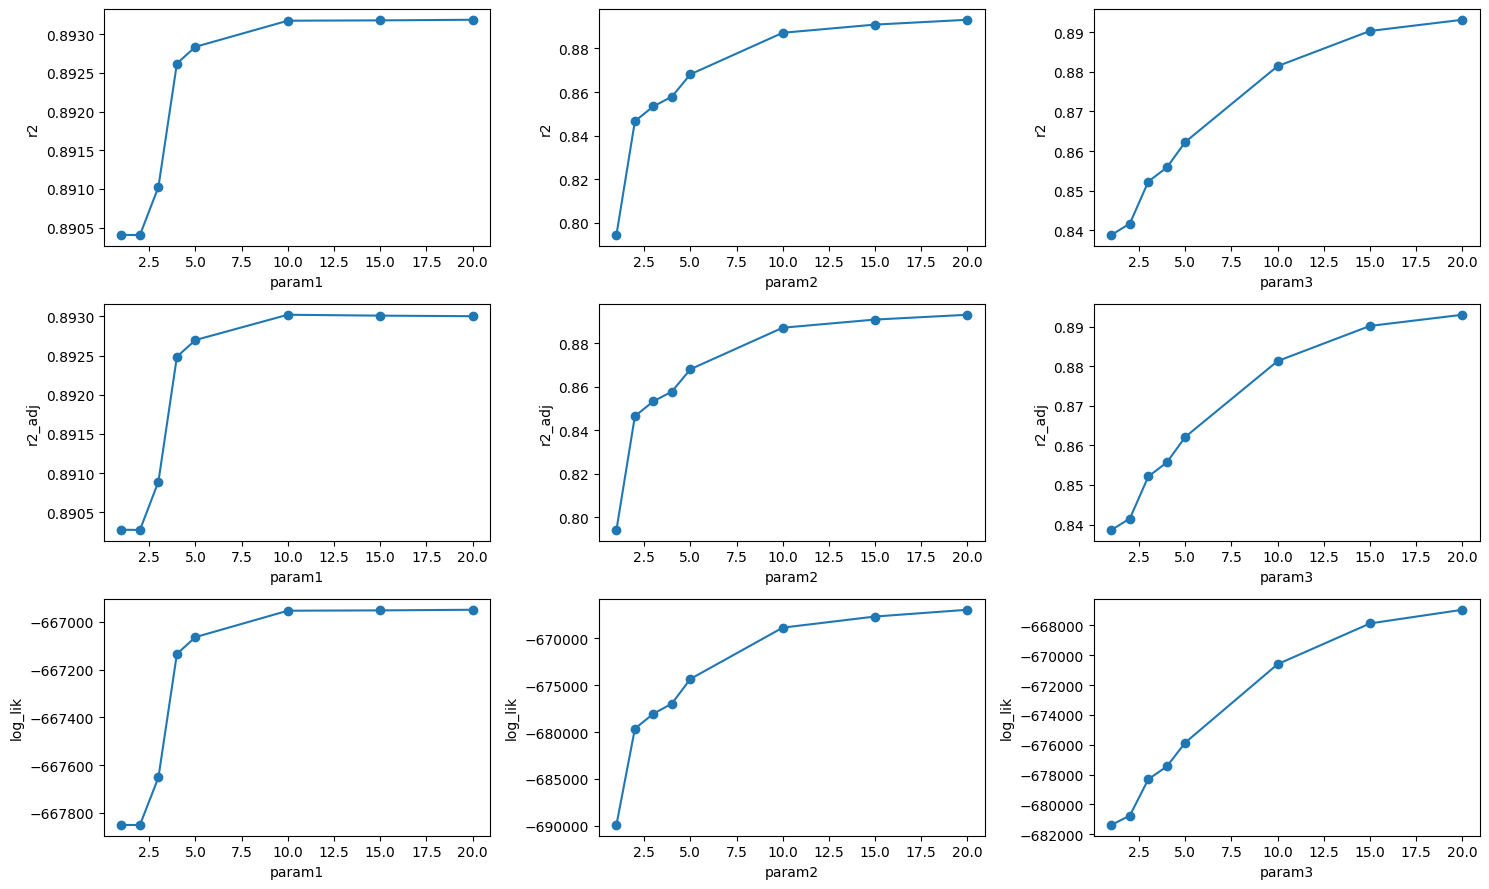

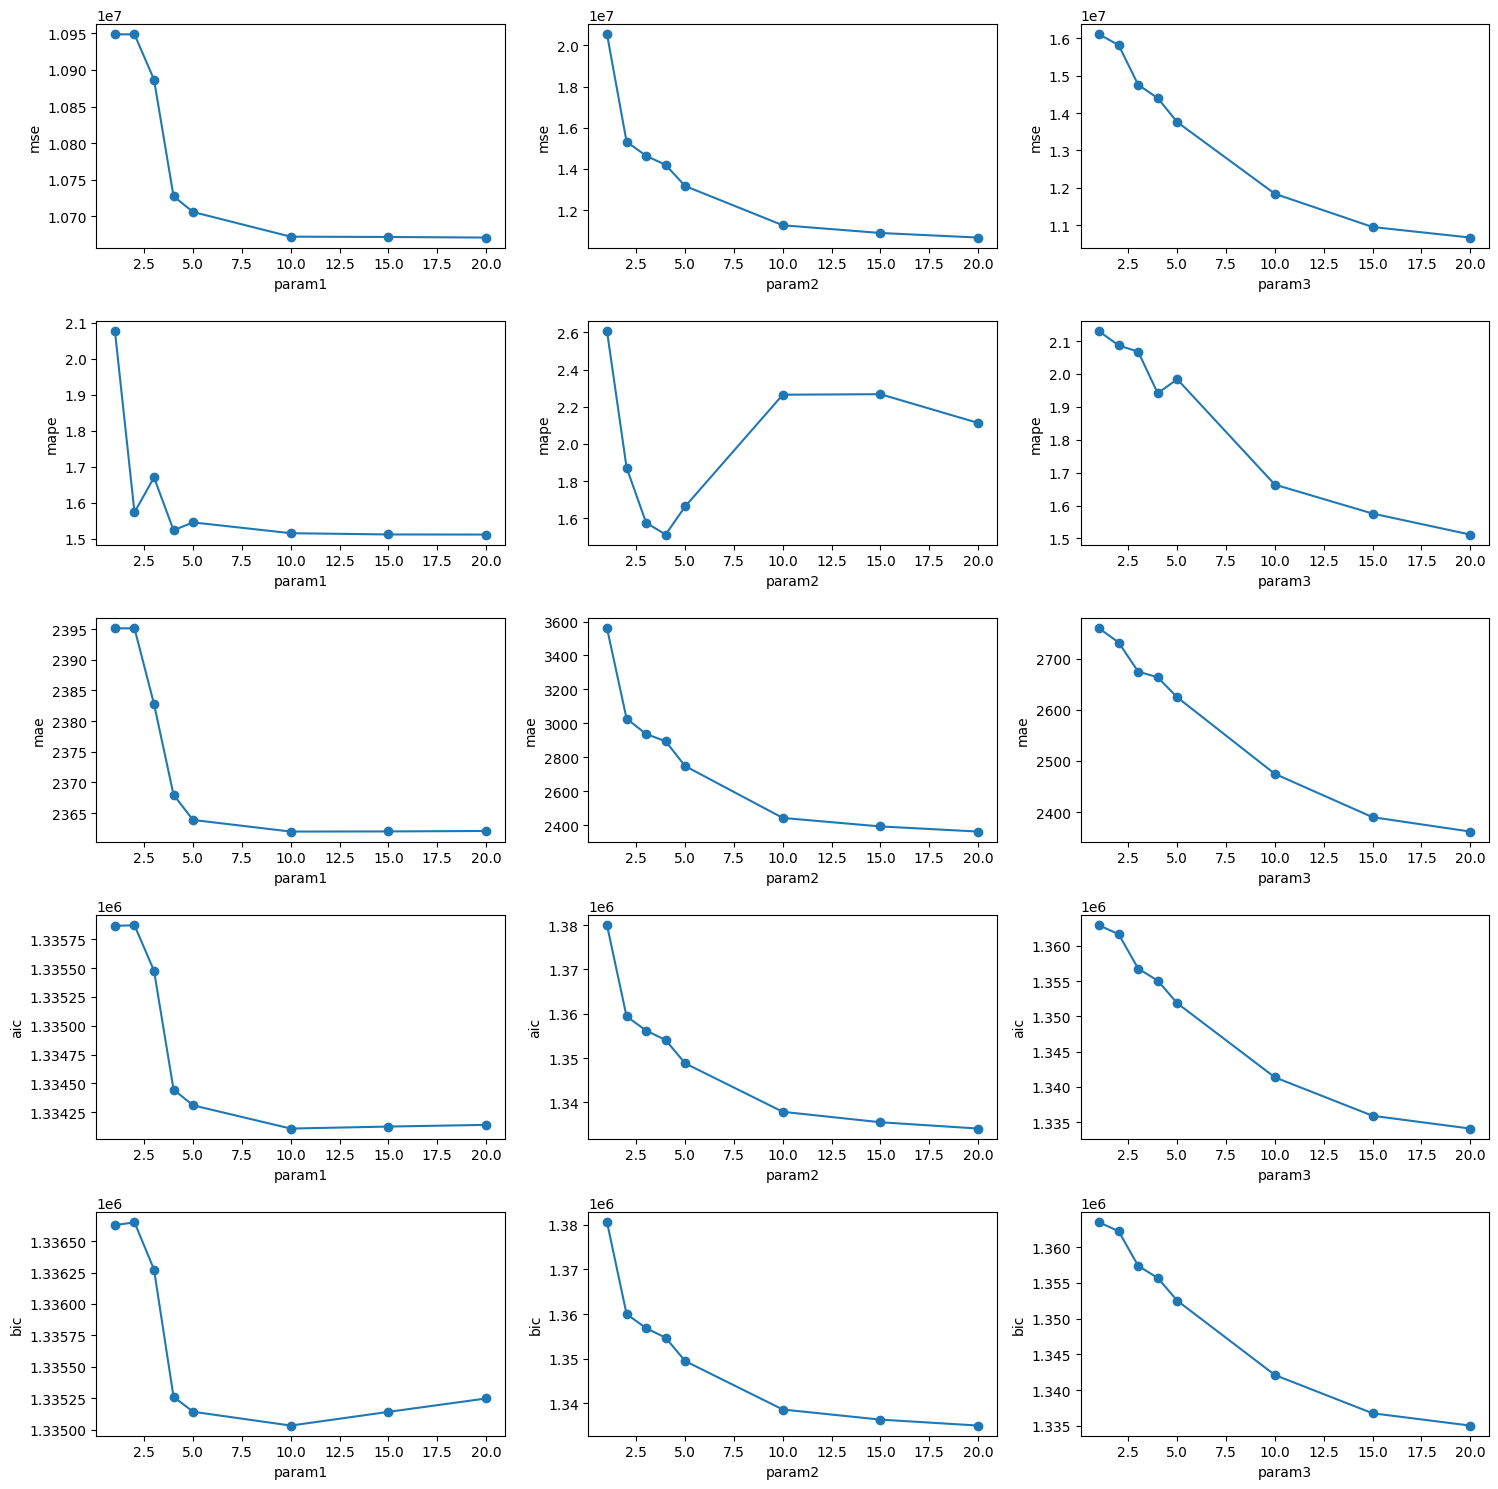

In [137]:
# add column with sum of permutation parameters
res_df['param1'] = [i[0] for i in permutations]
res_df['param2'] = [i[1] for i in permutations]
res_df['param3'] = [i[2] for i in permutations]
res_df['param_sum'] = np.sum(permutations, axis=1)

# = = = = = = = = 

metrics = max_metrics
fig, axes = plt.subplots(len(metrics),3, figsize=(15, len(metrics)*3))

for idx, metric in enumerate(metrics):    
    res_df.groupby('param1')[metric].max().plot(marker='o', ax=axes[idx, 0])
    res_df.groupby('param2')[metric].max().plot(marker='o', ax=axes[idx, 1])
    res_df.groupby('param3')[metric].max().plot(marker='o', ax=axes[idx, 2])

    for ax in axes[idx, ]:
        ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

# = = = = = = = = 

metrics = min_metrics
fig, axes = plt.subplots(len(metrics),3, figsize=(15, len(metrics)*3))

for idx, metric in enumerate(metrics):    
    res_df.groupby('param1')[metric].min().plot(marker='o', ax=axes[idx, 0])
    res_df.groupby('param2')[metric].min().plot(marker='o', ax=axes[idx, 1])
    res_df.groupby('param3')[metric].min().plot(marker='o', ax=axes[idx, 2])

    for ax in axes[idx, ]:
        ax.set_ylabel(metric)

plt.tight_layout()
plt.show()